Copyright (c) Zhizuo Chen (aka George)

Permission is hereby granted, free of charge, to use, copy, modify, and distribute this code for any purpose, provided that this notice is included in all copies or substantial portions of the code.

This code is provided "as is", without warranty of any kind, express or implied. The author shall not be liable for any damages or consequences arising from its use.

This file is associated with my arXiv preprint: https://arxiv.org/abs/2511.17598

For questions or bug reports, contact: zhizuo.chen@outlook.com

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, math, random, scipy, pickle
import joblib
from copy import deepcopy
from functools import partial
import UBZ_NVMDP_ENVT, UBZ_NVMDP_TBL

# Initialization

In [2]:
#Global parameter settings.
global TRICK_GWD_D, PUN_LOCS

#The function that adds normal noise with smaller variance noise to the costs.
nnoi_f = partial(UBZ_NVMDP_ENVT.norm_noi_f, std = float(1. / scipy.stats.norm.ppf(.95)))
#The function that adds normal noise with larger variance noise to the costs.
l_nnoi_f = partial(UBZ_NVMDP_ENVT.norm_noi_f, std = float(5. / scipy.stats.norm.ppf(.95)))
#The time-based function that decides the strength of the wind.
def tw_wind_f(t):
    #Check the current time.
    mod = t % 6
    #Decide the strength:
    if 0 == mod: return (0, 3, 4)
    elif mod < 5: return (2, 0, 4)
    else: return (2, 3, 0)
    #func-end

#A typical gridworld parameter setting (except the cost noise function).
TRICK_GWD_D = {
    'length': 8, #The length of the gridworld.
    'width': 3, #The width of the gridworld.
    'windz': 5, #The coordinate of the start location.
    'beg': (1, 1), #The start coordinate of the windy zone.
    'tgt': (8, 3), #The coordinate of the target location.
    'step_cost': -10., #The cost of taking each step (without noise).
    'wind_f': tw_wind_f #The function that decides strength of the wind.
}
#The punishment locations.
PUN_LOCS = {(3, 1), (4, 2)}

In [3]:
#Genereate the test result for a Q-learning algorithm.
def test_q_learn(ttenvt, test_epi_num, test_rounds, horiz, train_eps, av_init_f, alpha):

    #The container of the returns between each test round.
    rets = list()
    #The container of steps taken between each test round.
    steps = list()
    #The container of trajectory lengths.
    traj_lens = list()
    #Initialize the action-value container.
    av_res = av_init_f()
    #Initialize an action selector.
    act_sel_ = partial(av_res.eps_act_sel_, eps = train_eps)
    #Choose whether to use the generialized q-learning algorithm based on the class of {av_res}.
    q_learn_algr = UBZ_NVMDP_TBL.geq_learn if isinstance(av_res, UBZ_NVMDP_TBL.Maxmin_AvalStruc) else UBZ_NVMDP_TBL.q_learn
    
    #Run the q-learning algorithm for {test_epi_num} × {test_rounds} episodes in total.
    for _ in range(test_rounds):
        #Run the q-learning algorithm for {test_epi_num} episodes before testing.
        q_learn_algr(horiz, ttenvt, act_sel_, test_epi_num, alpha, av_res)
        #Generate the greedy policy regarding the current action-values.
        xpol = av_res.av2pol(eps = 0.)
        #Test the tricky gridworld environment for one time with the greedy policy.
        (tnts, sta_seq, act_seq, gam_seq, rwd_seq) = UBZ_NVMDP_TBL.run_envt(horiz, ttenvt, xpol)
        #Calculate & store the returns.
        ret_seq = UBZ_NVMDP_TBL.rwd_2_ret(gam_seq, rwd_seq, last_v = 0.)
        rets.append(ret_seq[0])
        #Record the steps taken thus far.
        steps.append(alpha.taken_steps)
        #Record the length of the current trajectory.
        traj_lens.append(len(sta_seq))
        #for-end
    
    #Return the results.
    return rets, steps, traj_lens, (sta_seq, act_seq, gam_seq, rwd_seq)
    #func-end

In [4]:
#Repeatedly test the Q-learning algorithm for {rptd} times.
def rptest_q_learn(label, rptd, ttenvt, test_epi_num, test_rounds, horiz, train_eps, av_init_f, alpha, sp_num, ovw = False):
    
    #Load the previous result file.
    try:
        with open("Tricky_Gridworld_results.pkl", 'rb') as file: rptest_q_res = pickle.load(file)
    except FileNotFoundError: rptest_q_res = dict()
    #Return if {ovw} is False and the records already exists.
    if (not ovw) and (label in rptest_q_res.keys()):
        print("!!rptest_q_learn.warning: skipped overwriting existing results!!")
        return
        #if-end
    
    #Create the partial function for parallelism.
    test_q_para = partial(test_q_learn, test_epi_num = test_epi_num, test_rounds = test_rounds, horiz = horiz, 
        train_eps = train_eps, av_init_f = av_init_f, alpha = alpha)
    #The container of all returns, all steps, all trajectory lengths, and all final state sequences.
    rets_all, steps_all, traj_lens_all, sta_seq_all = list(), list(), list(), list()
    
    #Create a pool with {sp_num} processes.
    with joblib.Parallel(n_jobs = sp_num, return_as = 'generator_unordered') as para:
        #The results are returned in arbitrary order.
        for rets, steps, traj_lens, fepi_seq in para(joblib.delayed(test_q_para)(ttenvt) for _ in range(rptd)):
            #Store the returns, steps, trajectory lengths, and final state sequence.
            rets_all.append(rets)
            steps_all.append(steps)
            traj_lens_all.append(traj_lens)
            sta_seq_all.append(fepi_seq[0])
            #for-end
        #with-end

    #The estimated episode number that reaching the optimal trajectory.
    estepi_nums = list()
    #The sequence of whether the last trajectory passes the punishment locations.
    ppun_flags = list()
    #Loop through all repeated tests.
    for traj_len_seq, sta_seq in zip(traj_lens_all, sta_seq_all):
        #Get the estimated episode number that reaching the optimal trajectory.
        for i in range(-1, -test_rounds - 1, -1):
            if traj_len_seq[i] > 13: break
            #for-end
        estepi_nums.append((i + test_rounds + 2) * test_epi_num)
        #Check whether the last trajectory passes the punishment locations.
        ppun_flags.append(bool(len(PUN_LOCS.intersection(sta_seq)) > 0))
        #for-end
    
    #Save the average returns, estimated episode numbers, and flags.
    rptest_q_res[label] = (rets_all, steps_all, estepi_nums, ppun_flags)
    with open("Tricky_Gridworld_results.pkl", 'wb') as file: pickle.dump(rptest_q_res, file)
    #func-end

In [5]:
#Initialize the environment (without punishment locations).
tgw = UBZ_NVMDP_ENVT.TrickyGWD(TRICK_GWD_D, l_nnoi_f)
#Initialize the environment (enabling punishment locations within the whole time horizon).
tgw_pun = UBZ_NVMDP_ENVT.Pun_TrickyGWD(9999, PUN_LOCS, 1.02, TRICK_GWD_D, l_nnoi_f)
#Initialize the environment (enabling punishment locations within time window [0, {PUN_HRZN})).
tgw_pun2 = UBZ_NVMDP_ENVT.Pun_TrickyGWD(50, PUN_LOCS, 1.02, TRICK_GWD_D, l_nnoi_f)
#Initialize the environment (with smaller variance noise, enabling punishment locations within the whole time horizon).
tgw_pun_svn = UBZ_NVMDP_ENVT.Pun_TrickyGWD(9999, PUN_LOCS, 1.02, TRICK_GWD_D, nnoi_f)
#Initialize the environment (with smaller variance noise, enabling punishment locations within time window [0, {PUN_HRZN})).
tgw_pun2_svn = UBZ_NVMDP_ENVT.Pun_TrickyGWD(50, PUN_LOCS, 1.02, TRICK_GWD_D, nnoi_f)
#Initialize the environment (with larger punishment gamma, enabling punishment locations within time window [0, {PUN_HRZN})).
tgw_pun3 = UBZ_NVMDP_ENVT.Pun_TrickyGWD(50, PUN_LOCS, 1.05, TRICK_GWD_D, l_nnoi_f)
#Initialize a policy.
pol0 = UBZ_NVMDP_TBL.PolStruc(tgw.actions())

# Show the trajectory of one episode

In [6]:
#Test the windy gridworld environment for one episode.
(tnts, sta_seq, act_seq, gam_seq, rwd_seq) = UBZ_NVMDP_TBL.run_envt(200, tgw_pun2, pol0)
#Calculate the returns.
ret_seq = UBZ_NVMDP_TBL.rwd_2_ret(gam_seq, rwd_seq, last_v = 0.)

#The number of states showing in one line before a line break.
sta_one_line = 5
solmo = sta_one_line - 1
#Show the trace of the car.
t0, te = tnts[0], tnts[1]
for t in range(t0, te + 1):
    #Show the current state & action:
    i = t - t0
    print("%d:" % t, sta_seq[i], "%s$%.2f-> " % (act_seq[i].upper(), rwd_seq[i]), end = '')
    #Line break:
    if solmo == i % sta_one_line: print('\n')
    #for-end
#Show the last state.
print("%d:" % (te + 1), sta_seq[-1])

0: (1, 1) L$-9.21-> 1: (1, 1) L$-7.65-> 2: (1, 1) U$-11.22-> 3: (1, 2) D$-13.74-> 4: (1, 1) U$-6.31-> 

5: (1, 2) L$-12.09-> 6: (1, 2) U$-9.00-> 7: (1, 3) R$-8.40-> 8: (2, 3) D$-11.60-> 9: (2, 2) D$-9.90-> 

10: (2, 1) U$-16.98-> 11: (2, 2) R$-10.61-> 12: (3, 2) L$-12.19-> 13: (2, 2) D$-10.27-> 14: (2, 1) R$-12.89-> 

15: (3, 1) U$-10.19-> 16: (3, 2) R$-13.94-> 17: (4, 2) R$-12.30-> 18: (5, 2) U$-11.40-> 19: (5, 3) D$-13.32-> 

20: (3, 2) R$-13.12-> 21: (4, 2) R$-4.90-> 22: (5, 2) L$-13.77-> 23: (2, 2) R$-14.86-> 24: (3, 2) U$-7.71-> 

25: (3, 3) U$-3.10-> 26: (3, 3) L$-15.31-> 27: (2, 3) U$-7.15-> 28: (2, 3) D$-16.09-> 29: (2, 2) R$-7.33-> 

30: (3, 2) R$-12.50-> 31: (4, 2) D$-4.53-> 32: (4, 1) U$-13.48-> 33: (4, 2) R$-7.64-> 34: (5, 2) U$-15.22-> 

35: (3, 3) U$-14.13-> 36: (3, 3) D$-7.56-> 37: (3, 2) R$-11.98-> 38: (4, 2) R$-11.46-> 39: (5, 2) R$-7.25-> 

40: (4, 2) D$-13.65-> 41: (4, 1) D$-10.58-> 42: (4, 1) D$-13.70-> 43: (4, 1) U$-13.88-> 44: (4, 2) U$-11.29-> 

45: (4, 3) L$-12.

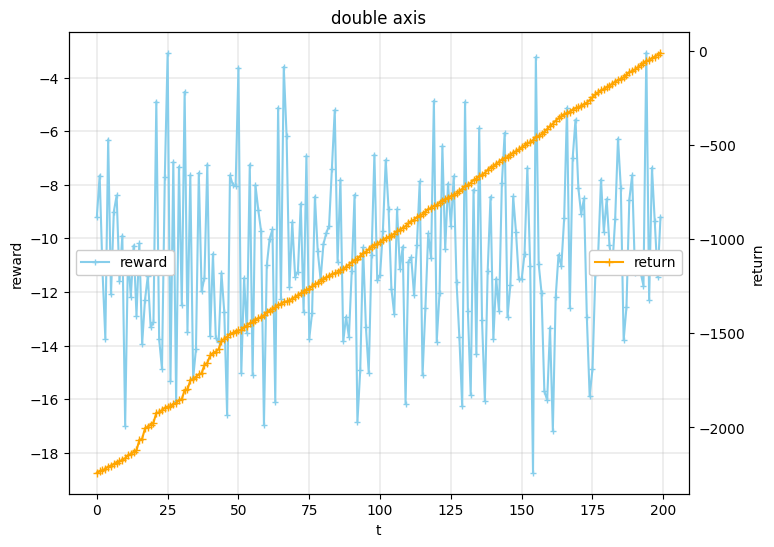

In [7]:
#Double y-axis.
(fig, ax) = plt.subplots(figsize = (8, 6))
#Twin object for two different y-axis on the sample plot.
ax2 = ax.twinx()
#Set the names for the axes.
ax.set_xlabel('t')
ax.set_ylabel('reward')
ax2.set_ylabel('return')
#Plot the reward.
ax.plot(rwd_seq, color = 'skyblue', marker = '+', markersize = 4)
ax2.plot(ret_seq, color = 'orange', marker = '+', markersize = 6)
ax.legend(['reward'], loc = 'center left', framealpha = 1.)
ax2.legend(['return'], loc = 'center right', framealpha = 1.)
ax.grid(True, linewidth = .3)
ax2.set_title("double axis")
plt.show()

In [8]:
#Show the γ values that are greater than one.
for i, gamma in enumerate(gam_seq):
    if gamma > 1.: print(i, gamma)
    #for-end

14 1.02
16 1.02
20 1.02
30 1.02
32 1.02
37 1.02
39 1.02
43 1.02


# Test Dynamic Programming Algorithms

In [9]:
#Specify a test time & state.
test_t_sta = (30, (7, 2))
#Get the actions.
actions_2 = list(tgw.actions())
#Initialize containers of state-values & action-values.
random.shuffle(actions_2)

## DP Policy Evaluation (without punishment locations)

In [10]:
print("Actions in the action-value container are:\n", actions_2)
sv_res = UBZ_NVMDP_TBL.SValStruc()
av_res = UBZ_NVMDP_TBL.AValStruc(actions_2)
#Initialize a policy.
random.shuffle(actions_2)
print("\nActions in the policy are:\n", actions_2)
pol0 = UBZ_NVMDP_TBL.PolStruc(actions_2)

Actions in the action-value container are:
 ['d', 'r', 'u', 'l']

Actions in the policy are:
 ['u', 'r', 'd', 'l']


In [11]:
sv_res.get_(test_t_sta), av_res.get_sta_allav_(test_t_sta), pol0.get_sta_pol_(test_t_sta)

(0.0,
 {'d': 0.0, 'r': 0.0, 'u': 0.0, 'l': 0.0},
 {'u': 0.25, 'r': 0.25, 'd': 0.25, 'l': 0.25})

In [12]:
#Learn the state- & action- values.
UBZ_NVMDP_TBL.dp_pol_eval(0, 200, tgw, pol0, sv_res, av_res)

In [13]:
sv_res.get_(test_t_sta), av_res.get_sta_allav_(test_t_sta), pol0.get_sta_pol_(test_t_sta)

(-1563.3204112750893,
 {'d': -1563.3158872894855,
  'r': -1563.2853703622277,
  'u': -1563.3107650205823,
  'l': -1563.369622428062},
 {'u': 0.25, 'r': 0.25, 'd': 0.25, 'l': 0.25})

In [14]:
len(sv_res), len(av_res), len(pol0)

(4824, 4800, 4800)

## DP Value Iteration (without punishment locations)

In [15]:
#Initialize containers of state-values & action-values.
sv_res = UBZ_NVMDP_TBL.SValStruc()
av_res = UBZ_NVMDP_TBL.AValStruc(actions_2)
#Learn the optimal policy.
q_pol = UBZ_NVMDP_TBL.dp_val_iter(0, 200, tgw, sv_res, av_res)

In [16]:
#Learn the state- & action- values from the policy derived from the previous action-values.
UBZ_NVMDP_TBL.dp_pol_eval(0, 200, tgw, q_pol, sv_res, av_res)

In [17]:
sv_res.get_(test_t_sta), av_res.get_sta_allav_(test_t_sta), q_pol.get_sta_pol_(test_t_sta)

(-119.34219505791079,
 {'u': -119.34219505791079,
  'r': -119.34219505791079,
  'd': -119.34219505791079,
  'l': -119.34219505791079},
 {'l': 1.0, 'r': 0.0, 'u': 0.0, 'd': 0.0})

In [18]:
#Calculate the state-values from the action-values and learned policy.
sv_res_2 = UBZ_NVMDP_TBL.av_2_sv(20, 200, tgw.states(), av_res, q_pol)

In [19]:
sv_res_2.get(test_t_sta)

-119.34219505791079

In [20]:
#Test the windy gridworld environment for one time.
(tnts, sta_seq, act_seq, gam_seq, rwd_seq) = UBZ_NVMDP_TBL.run_envt(200, tgw, q_pol)
#Calculate the returns.
ret_seq = UBZ_NVMDP_TBL.rwd_2_ret(gam_seq, rwd_seq, last_v = 0.)

#The number of states showing in one line before a line break.
sta_one_line = 6
solmo = sta_one_line - 1
#Show the trace of the car.
t0, te = tnts[0], tnts[1]
for t in range(t0, te + 1):
    #Show the current state & action:
    i = t - t0
    print("%d:" % t, sta_seq[i], "%s$%.2f-> " % (act_seq[i].upper(), rwd_seq[i]), end = '')
    #Line break:
    if solmo == i % sta_one_line: print('\n')
    #for-end
#Show the last state.
print("%d:" % (te + 1), sta_seq[-1])

0: (1, 1) L$-9.00-> 1: (1, 1) L$-12.52-> 2: (1, 1) R$-9.32-> 3: (2, 1) R$-11.98-> 4: (3, 1) R$-10.60-> 5: (4, 1) R$-9.03-> 

6: (5, 1) R$-6.96-> 7: (6, 1) U$-8.02-> 8: (6, 2) U$-9.41-> 9: (6, 3) U$-12.59-> 10: (6, 3) R$-11.45-> 11: (7, 3) R$-11.89-> 

12: (8, 3)


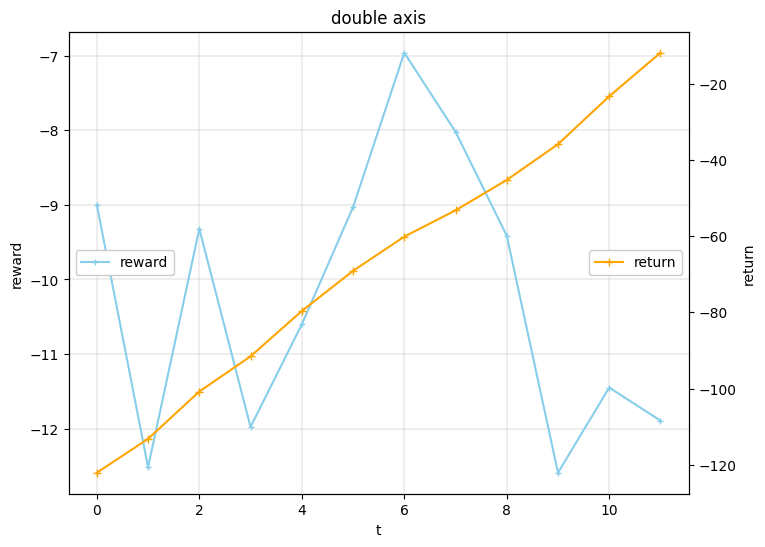

In [21]:
#Double y-axis.
(fig, ax) = plt.subplots(figsize = (8, 6))
#Twin object for two different y-axis on the sample plot.
ax2 = ax.twinx()
#Set the names for the axes.
ax.set_xlabel('t')
ax.set_ylabel('reward')
ax2.set_ylabel('return')
#Plot the reward.
ax.plot(rwd_seq, color = 'skyblue', marker = '+', markersize = 4)
ax2.plot(ret_seq, color = 'orange', marker = '+', markersize = 6)
ax.legend(['reward'], loc = 'center left', framealpha = 1.)
ax2.legend(['return'], loc = 'center right', framealpha = 1.)
ax.grid(True, linewidth = .3)
ax2.set_title("double axis")
plt.show()

## DP Value Iteration (with punishment locations)

In [22]:
#Initialize containers of state-values & action-values.
sv_res = UBZ_NVMDP_TBL.SValStruc()
av_res = UBZ_NVMDP_TBL.AValStruc(actions_2)
#Learn the optimal policy.
q_pol = UBZ_NVMDP_TBL.dp_val_iter(0, 200, tgw_pun, sv_res, av_res)

In [23]:
#Test the windy gridworld environment for one time.
(tnts, sta_seq, act_seq, gam_seq, rwd_seq) = UBZ_NVMDP_TBL.run_envt(200, tgw_pun, q_pol)
#Calculate the returns.
ret_seq = UBZ_NVMDP_TBL.rwd_2_ret(gam_seq, rwd_seq, last_v = 0.)

#The number of states showing in one line before a line break.
sta_one_line = 6
solmo = sta_one_line - 1
#Show the trace of the car.
t0, te = tnts[0], tnts[1]
for t in range(t0, te + 1):
    #Show the current state & action:
    i = t - t0
    print("%d:" % t, sta_seq[i], "%s$%.2f-> " % (act_seq[i].upper(), rwd_seq[i]), end = '')
    #Line break:
    if solmo == i % sta_one_line: print('\n')
    #for-end
#Show the last state.
print("%d:" % (te + 1), sta_seq[-1])

0: (1, 1) R$-6.36-> 1: (2, 1) U$-11.07-> 2: (2, 2) R$-7.36-> 3: (3, 2) U$-12.23-> 4: (3, 3) R$-3.07-> 5: (4, 3) R$-11.89-> 

6: (5, 3) R$-10.51-> 7: (6, 3) U$-12.40-> 8: (6, 3) U$-6.67-> 9: (6, 3) U$-11.84-> 10: (6, 3) R$-7.51-> 11: (7, 3) R$-5.44-> 

12: (8, 3)


## DP Value Iteration (with both punishment locations & punshiment time horizon)

In [24]:
#Initialize containers of state-values & action-values.
sv_res = UBZ_NVMDP_TBL.SValStruc()
av_res = UBZ_NVMDP_TBL.AValStruc(actions_2)
#Learn the optimal policy.
q_pol = UBZ_NVMDP_TBL.dp_val_iter(0, 200, tgw_pun2, sv_res, av_res)

In [25]:
#Test the windy gridworld environment for one time.
(tnts, sta_seq, act_seq, gam_seq, rwd_seq) = UBZ_NVMDP_TBL.run_envt(200, tgw_pun2, q_pol)
#Calculate the returns.
ret_seq = UBZ_NVMDP_TBL.rwd_2_ret(gam_seq, rwd_seq, last_v = 0.)

#The number of states showing in one line before a line break.
sta_one_line = 6
solmo = sta_one_line - 1
#Show the trace of the car.
t0, te = tnts[0], tnts[1]
for t in range(t0, te + 1):
    #Show the current state & action:
    i = t - t0
    print("%d:" % t, sta_seq[i], "%s$%.2f-> " % (act_seq[i].upper(), rwd_seq[i]), end = '')
    #Line break:
    if solmo == i % sta_one_line: print('\n')
    #for-end
#Show the last state.
print("%d:" % (te + 1), sta_seq[-1])

0: (1, 1) R$-11.31-> 1: (2, 1) U$-8.72-> 2: (2, 2) R$-12.10-> 3: (3, 2) U$-8.67-> 4: (3, 3) R$-6.00-> 5: (4, 3) R$-6.25-> 

6: (5, 3) R$-14.47-> 7: (6, 3) U$-9.62-> 8: (6, 3) U$-12.54-> 9: (6, 3) U$-15.12-> 10: (6, 3) R$-10.75-> 11: (7, 3) R$-13.95-> 

12: (8, 3)


## DP Value Iteration (with both punishment locations & punshiment time horizon, larger γ values)

In [26]:
#Initialize containers of state-values & action-values.
sv_res = UBZ_NVMDP_TBL.SValStruc()
av_res = UBZ_NVMDP_TBL.AValStruc(actions_2)
#Learn the optimal policy.
q_pol = UBZ_NVMDP_TBL.dp_val_iter(0, 200, tgw_pun3, sv_res, av_res)

In [27]:
#Test the windy gridworld environment for one time.
(tnts, sta_seq, act_seq, gam_seq, rwd_seq) = UBZ_NVMDP_TBL.run_envt(200, tgw_pun3, q_pol)
#Calculate the returns.
ret_seq = UBZ_NVMDP_TBL.rwd_2_ret(gam_seq, rwd_seq, last_v = 0.)

#The number of states showing in one line before a line break.
sta_one_line = 6
solmo = sta_one_line - 1
#Show the trace of the car.
t0, te = tnts[0], tnts[1]
for t in range(t0, te + 1):
    #Show the current state & action:
    i = t - t0
    print("%d:" % t, sta_seq[i], "%s$%.2f-> " % (act_seq[i].upper(), rwd_seq[i]), end = '')
    #Line break:
    if solmo == i % sta_one_line: print('\n')
    #for-end
#Show the last state.
print("%d:" % (te + 1), sta_seq[-1])

0: (1, 1) R$-13.22-> 1: (2, 1) U$-13.87-> 2: (2, 2) R$-10.81-> 3: (3, 2) U$-8.03-> 4: (3, 3) R$-8.03-> 5: (4, 3) R$-14.24-> 

6: (5, 3) R$-8.38-> 7: (6, 3) U$-10.31-> 8: (6, 3) U$-12.96-> 9: (6, 3) U$-10.58-> 10: (6, 3) R$-8.50-> 11: (7, 3) R$-6.09-> 

12: (8, 3)


Start time that is not 0 (with punishment locations)

In [28]:
#Test another start & end time.
sv_res = UBZ_NVMDP_TBL.SValStruc()
av_res = UBZ_NVMDP_TBL.AValStruc(actions_2)
#Learn the state- & action- values from the policy derived from the previous action-values.
q_pol = UBZ_NVMDP_TBL.dp_val_iter(30, 99, tgw_pun, sv_res, av_res)

In [29]:
#Test the windy gridworld environment for one time.
(tnts, sta_seq, act_seq, gam_seq, rwd_seq) = UBZ_NVMDP_TBL.run_envt(200, tgw_pun, q_pol)
#Calculate the returns.
ret_seq = UBZ_NVMDP_TBL.rwd_2_ret(gam_seq, rwd_seq, last_v = 0.)

#The number of states showing in one line before a line break.
sta_one_line = 6
solmo = sta_one_line - 1
#Show the trace of the car.
t0, te = tnts[0], tnts[1]
for t in range(t0, te + 1):
    #Show the current state & action:
    i = t - t0
    print("%d:" % t, sta_seq[i], "%s$%.2f-> " % (act_seq[i].upper(), rwd_seq[i]), end = '')
    #Line break:
    if solmo == i % sta_one_line: print('\n')
    #for-end
#Show the last state.
print("%d:" % (te + 1), sta_seq[-1])

0: (1, 1) L$-7.57-> 1: (1, 1) U$-9.53-> 2: (1, 2) R$-7.43-> 3: (2, 2) U$-8.64-> 4: (2, 3) R$-13.83-> 5: (3, 3) U$-9.31-> 

6: (3, 3) D$-6.23-> 7: (3, 2) D$-13.21-> 8: (3, 1) L$-12.69-> 9: (2, 1) U$-10.51-> 10: (2, 2) D$-12.68-> 11: (2, 1) D$-16.26-> 

12: (2, 1) U$-9.92-> 13: (2, 2) R$-11.78-> 14: (3, 2) U$-7.60-> 15: (3, 3) L$-12.81-> 16: (2, 3) D$-7.33-> 17: (2, 2) U$-10.70-> 

18: (2, 3) L$-5.99-> 19: (1, 3) U$-11.44-> 20: (1, 3) D$-7.27-> 21: (1, 2) L$-7.73-> 22: (1, 2) L$-9.62-> 23: (1, 2) U$-5.01-> 

24: (1, 3) L$-9.83-> 25: (1, 3) L$-12.28-> 26: (1, 3) R$-8.79-> 27: (2, 3) L$-6.80-> 28: (1, 3) U$-7.03-> 29: (1, 3) U$-7.56-> 

30: (1, 3) L$-12.98-> 31: (1, 3) L$-6.80-> 32: (1, 3) R$-10.43-> 33: (2, 3) R$-12.95-> 34: (3, 3) R$-3.92-> 35: (4, 3) R$-16.13-> 

36: (5, 3) R$-12.08-> 37: (6, 3) U$-3.72-> 38: (6, 3) U$-15.23-> 39: (6, 3) U$-13.68-> 40: (6, 3) R$-10.42-> 41: (7, 3) R$-10.10-> 

42: (8, 3)


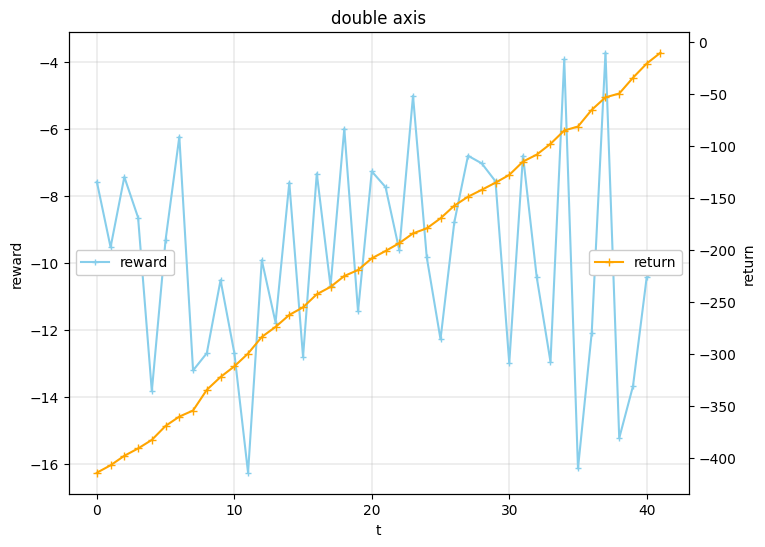

In [30]:
#Double y-axis.
(fig, ax) = plt.subplots(figsize = (8, 6))
#Twin object for two different y-axis on the sample plot.
ax2 = ax.twinx()
#Set the names for the axes.
ax.set_xlabel('t')
ax.set_ylabel('reward')
ax2.set_ylabel('return')
#Plot the reward.
ax.plot(rwd_seq, color = 'skyblue', marker = '+', markersize = 4)
ax2.plot(ret_seq, color = 'orange', marker = '+', markersize = 6)
ax.legend(['reward'], loc = 'center left', framealpha = 1.)
ax2.legend(['return'], loc = 'center right', framealpha = 1.)
ax.grid(True, linewidth = .3)
ax2.set_title("double axis")
plt.show()

# Test MC evaluation & control

In [31]:
#Specify a test time & state.
test_t_sta = (30, (3, 2))

## MC policy evaluation (without punishment locations)

In [32]:
#Initialize the containers.
sv_res = UBZ_NVMDP_TBL.SValStruc()
sv_ct_res = UBZ_NVMDP_TBL.SValStruc()
av_res = UBZ_NVMDP_TBL.AValStruc(tgw.actions())
av_ct_res = UBZ_NVMDP_TBL.AValStruc(tgw.actions())
#Initialize a policy.
pol = UBZ_NVMDP_TBL.PolStruc(tgw.actions())

In [33]:
#Test the Monte Carlo policy evaluation.
UBZ_NVMDP_TBL.mc_pol_eval(200, tgw, pol, 5000, sv_res, sv_ct_res, av_res, av_ct_res)

In [34]:
sv_res.get_(test_t_sta), sv_ct_res.get_(test_t_sta), av_ct_res.get_sta_allav_(test_t_sta)

(-1562.1934107816153, 431, {'l': 95, 'r': 107, 'u': 112, 'd': 117})

In [35]:
av_res.get_sta_allav_(test_t_sta), av_res.get_q_act_(test_t_sta)

({'l': -1560.2190516978196,
  'r': -1565.05559307852,
  'u': -1557.865854510158,
  'd': -1565.3215894960974},
 ('u', -1557.865854510158))

In [36]:
pol.get_sta_pol_(test_t_sta), pol.get_ml_act_(test_t_sta)

({'l': 0.25, 'r': 0.25, 'u': 0.25, 'd': 0.25}, ('l', 0.25))

## MC control (original version, without punishment locations)

In [37]:
#On-policy MC control (with ε-soft policies) for NVMDP (the original version).
def mc_control_esoft_orig(te, envt, pol, eps, ep_num, av_res, av_ct_res):
    
    #Calculate the probability for the ε-greedy action.
    gd_act_pr = 1. - eps + eps / len(envt.actions())
    
    #Run the environment for {ep_num} times.
    for ep in range(ep_num):

        #The sequences of states, actions, γ values, rewards, and returns in the test episode.
        sta_seq, act_seq, gam_seq, rwd_seq, ret_seq = list(), list(), list(), list(), list()
        #Initialize the start time & start state.
        t0, sta = envt.mu()
        
        #Iteration through the current episode.
        for t in range(t0, te):
            #Choose one action according to the specified policy.
            act = pol.select(t, sta)
            #Take one step forward.
            (n_sta, rwd, ts) = envt.step(t, sta, act)
            #Record the current state, action, γₜ₊₁(s, a, s'), and rₜ(s, a, s').
            sta_seq.append(sta)
            act_seq.append(act)
            gam_seq.append(envt.get_gamma(t, sta, act, n_sta))
            rwd_seq.append(rwd)
            #Break the loop if the current episode is ended.
            if ts: break
            #The next state {n_sta} becomes the current state in the next step.
            sta = n_sta
            #inner-for-end
        #Calculate the returns of the test episode.
        ret_seq = UBZ_NVMDP_TBL.rwd_2_ret(gam_seq, rwd_seq, last_v = 0. if ts else av_res.get_q_act_((t + 1, n_sta))[1])

        #Update the Monte Carlo estimates of action-values & the policy.
        for t, (sta, act, ret) in enumerate(zip(sta_seq, act_seq, ret_seq), start = t0):
            #Generate the time-state pair.
            t_sta = (t, sta)
            #Get & update the count of the current action-value.
            av_ct = int(av_ct_res.get_(t_sta, act)) + 1
            av_ct_res.update_(t_sta, act, av_ct)
            #Get & update the Monte Carlo estimate of the current action-value.
            av = av_res.get_(t_sta, act)
            av_res.update_(t_sta, act, av + (ret - av) / av_ct)
            #Find the ε-greedy action & update the policy.
            q_act = (av_res.get_q_act_(t_sta))[0]
            pol.update_(t_sta, {q_act: gd_act_pr})
            #inner-for-end
        #for-end
    #func-end

In [38]:
#Initialize the containers.
av_res = UBZ_NVMDP_TBL.AValStruc(tgw.actions())
av_ct_res = UBZ_NVMDP_TBL.AValStruc(tgw.actions())
#Initialize a policy.
pol = UBZ_NVMDP_TBL.PolStruc(tgw.actions())

In [39]:
#Test the on-policy Monte Carlo control.
mc_control_esoft_orig(200, tgw, pol, .05, 2_0000, av_res, av_ct_res)

In [40]:
#Test the on-policy Monte Carlo control (the original version).
av_res.get_sta_allav_(test_t_sta), av_res.get_q_act_(test_t_sta)

({'l': -1158.801781709502,
  'r': -1084.78231176029,
  'u': -1278.0484020138283,
  'd': -1473.5645467486027},
 ('r', -1084.78231176029))

In [41]:
pol.get_sta_pol_(test_t_sta), pol.get_ml_act_(test_t_sta)

({'l': 0.01250000000000003,
  'r': 0.9624999999999999,
  'u': 0.01250000000000003,
  'd': 0.01250000000000003},
 ('r', 0.9624999999999999))

In [42]:
#Test the policy derived from the action-values.
pol_2 = av_res.av2pol(eps = 0.)
#Test the windy gridworld environment for one time.
(tnts, sta_seq, act_seq, gam_seq, rwd_seq) = UBZ_NVMDP_TBL.run_envt(200, tgw, pol_2)
#Calculate the returns.
ret_seq = UBZ_NVMDP_TBL.rwd_2_ret(gam_seq, rwd_seq, last_v = 0.)

#The number of states showing in one line before a line break.
sta_one_line = 6
solmo = sta_one_line - 1
#Show the trace of the car.
t0, te = tnts[0], tnts[1]
for t in range(t0, te + 1):
    #Show the current state & action:
    i = t - t0
    print("%d:" % t, sta_seq[i], "%s$%.2f-> " % (act_seq[i].upper(), rwd_seq[i]), end = '')
    #Line break:
    if solmo == i % sta_one_line: print('\n')
    #for-end
#Show the last state.
print("%d:" % (te + 1), sta_seq[-1])

0: (1, 1) D$-6.88-> 1: (1, 1) U$-17.21-> 2: (1, 2) D$-6.50-> 3: (1, 1) D$-11.35-> 4: (1, 1) D$-7.09-> 5: (1, 1) U$-5.60-> 

6: (1, 2) L$-3.44-> 7: (1, 2) D$-7.01-> 8: (1, 1) L$-10.82-> 9: (1, 1) D$-12.35-> 10: (1, 1) R$-13.44-> 11: (2, 1) D$-16.68-> 

12: (2, 1) R$-10.63-> 13: (3, 1) U$-13.57-> 14: (3, 2) L$-8.71-> 15: (2, 2) U$-12.19-> 16: (2, 3) L$-10.71-> 17: (1, 3) L$-10.28-> 

18: (1, 3) D$-12.22-> 19: (1, 2) U$-7.92-> 20: (1, 3) U$-9.12-> 21: (1, 3) D$-14.75-> 22: (1, 2) U$-9.54-> 23: (1, 3) D$-8.96-> 

24: (1, 2) L$-12.24-> 25: (1, 2) D$-12.08-> 26: (1, 1) L$-11.11-> 27: (1, 1) R$-7.73-> 28: (2, 1) U$-14.74-> 29: (2, 2) D$-11.99-> 

30: (2, 1) U$-9.95-> 31: (2, 2) U$-11.96-> 32: (2, 3) U$-10.17-> 33: (2, 3) U$-5.86-> 34: (2, 3) D$-6.79-> 35: (2, 2) R$-6.08-> 

36: (3, 2) R$-3.75-> 37: (4, 2) U$-8.72-> 38: (4, 3) R$-14.97-> 39: (5, 3) L$-7.66-> 40: (2, 3) L$-3.48-> 41: (1, 3) U$-10.76-> 

42: (1, 3) D$-5.39-> 43: (1, 2) U$-12.36-> 44: (1, 3) L$-6.67-> 45: (1, 3) L$-4.13-> 46: (1,

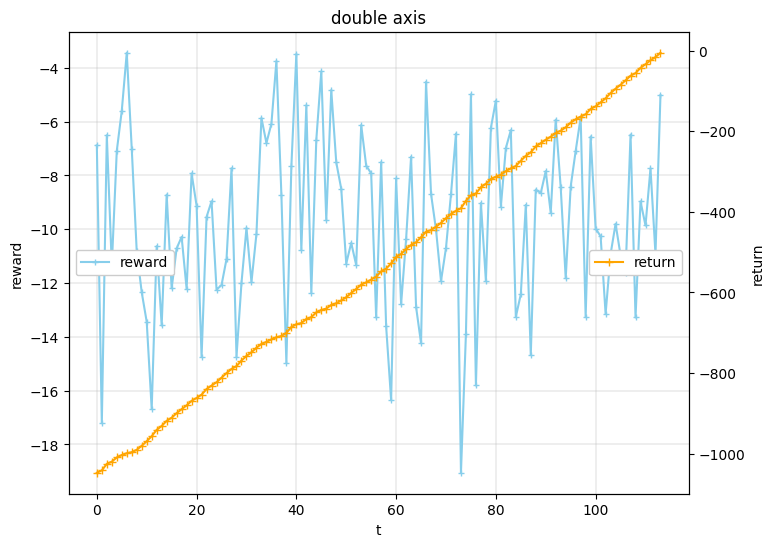

In [43]:
#Double y-axis.
(fig, ax) = plt.subplots(figsize = (8, 6))
#Twin object for two different y-axis on the sample plot.
ax2 = ax.twinx()
#Set the names for the axes.
ax.set_xlabel('t')
ax.set_ylabel('reward')
ax2.set_ylabel('return')
#Plot the reward.
ax.plot(rwd_seq, color = 'skyblue', marker = '+', markersize = 4)
ax2.plot(ret_seq, color = 'orange', marker = '+', markersize = 6)
ax.legend(['reward'], loc = 'center left', framealpha = 1.)
ax2.legend(['return'], loc = 'center right', framealpha = 1.)
ax.grid(True, linewidth = .3)
ax2.set_title("double axis")
plt.show()

## MC control (improved version, without punishment locations)

In [44]:
#Initialize the containers.
av_res = UBZ_NVMDP_TBL.AValStruc(tgw.actions())
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)
#Initialize a policy.
pol = UBZ_NVMDP_TBL.PolStruc(tgw.actions())

In [45]:
#Test the on-policy Monte Carlo control.
UBZ_NVMDP_TBL.mc_control_esoft(200, tgw, pol, .05, 2_0000, alpha, av_res)

In [46]:
av_res.get_sta_allav_(test_t_sta), av_res.get_q_act_(test_t_sta)

({'l': -1576.0336145323718,
  'r': -1581.0952819065583,
  'u': -1567.7362623237486,
  'd': -1581.1749239481803},
 ('u', -1567.7362623237486))

In [47]:
pol.get_sta_pol_(test_t_sta), pol.get_ml_act_(test_t_sta)

({'l': 0.01250000000000003,
  'r': 0.01250000000000003,
  'u': 0.9624999999999999,
  'd': 0.01250000000000003},
 ('u', 0.9624999999999999))

In [48]:
#Test the policy derived from the action-values.
pol_2 = av_res.av2pol(eps = 0.)
#Test the windy gridworld environment for one time.
(tnts, sta_seq, act_seq, gam_seq, rwd_seq) = UBZ_NVMDP_TBL.run_envt(200, tgw, pol_2)
#Calculate the returns.
ret_seq = UBZ_NVMDP_TBL.rwd_2_ret(gam_seq, rwd_seq, last_v = 0.)

#The number of states showing in one line before a line break.
sta_one_line = 6
solmo = sta_one_line - 1
#Show the trace of the car.
t0, te = tnts[0], tnts[1]
for t in range(t0, te + 1):
    #Show the current state & action:
    i = t - t0
    print("%d:" % t, sta_seq[i], "%s$%.2f-> " % (act_seq[i].upper(), rwd_seq[i]), end = '')
    #Line break:
    if solmo == i % sta_one_line: print('\n')
    #for-end
#Show the last state.
print("%d:" % (te + 1), sta_seq[-1])

0: (1, 1) R$-9.30-> 1: (2, 1) U$-7.46-> 2: (2, 2) L$-13.69-> 3: (1, 2) D$-8.06-> 4: (1, 1) D$-9.49-> 5: (1, 1) L$-12.66-> 

6: (1, 1) L$-10.53-> 7: (1, 1) U$-6.09-> 8: (1, 2) L$-6.30-> 9: (1, 2) L$-10.18-> 10: (1, 2) R$-9.58-> 11: (2, 2) L$-12.74-> 

12: (1, 2) D$-9.56-> 13: (1, 1) D$-13.79-> 14: (1, 1) R$-4.45-> 15: (2, 1) R$-11.61-> 16: (3, 1) R$-4.60-> 17: (4, 1) D$-8.50-> 

18: (4, 1) R$-7.20-> 19: (5, 1) U$-12.39-> 20: (3, 2) U$-10.64-> 21: (3, 3) R$-15.05-> 22: (4, 3) U$-11.63-> 23: (4, 3) R$-11.11-> 

24: (5, 3) R$-9.71-> 25: (6, 3) U$-11.90-> 26: (6, 3) D$-8.71-> 27: (6, 2) U$-12.40-> 28: (6, 3) R$-12.02-> 29: (7, 3) R$-14.56-> 

30: (8, 3)


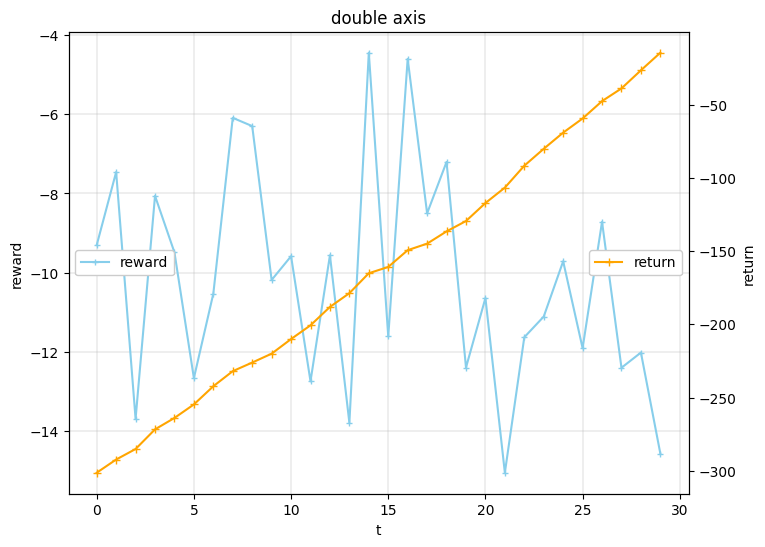

In [49]:
#Double y-axis.
(fig, ax) = plt.subplots(figsize = (8, 6))
#Twin object for two different y-axis on the sample plot.
ax2 = ax.twinx()
#Set the names for the axes.
ax.set_xlabel('t')
ax.set_ylabel('reward')
ax2.set_ylabel('return')
#Plot the reward.
ax.plot(rwd_seq, color = 'skyblue', marker = '+', markersize = 4)
ax2.plot(ret_seq, color = 'orange', marker = '+', markersize = 6)
ax.legend(['reward'], loc = 'center left', framealpha = 1.)
ax2.legend(['return'], loc = 'center right', framealpha = 1.)
ax.grid(True, linewidth = .3)
ax2.set_title("double axis")
plt.show()

# Test TD evaluation

In [50]:
#Specify a test time & state.
test_t_sta = (20, (4, 3))

## Policy Evaluation by TD(0) (without punishment locations)

In [51]:
#Initialize the state-value container.
sv_res = UBZ_NVMDP_TBL.SValStruc()
#Initialize a policy.
pol = UBZ_NVMDP_TBL.PolStruc(tgw.actions())
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Test TD(0) for policy evaluation.
UBZ_NVMDP_TBL.td0(200, tgw, pol, 5000, alpha, sv_res)

In [52]:
sv_res.get_(test_t_sta), pol.get_sta_pol_(test_t_sta), pol.get_ml_act_(test_t_sta)

(-285.18646745410075,
 {'l': 0.25, 'r': 0.25, 'u': 0.25, 'd': 0.25},
 ('l', 0.25))

# Q-learning

## Classic Q-learning for Stationary Environments

In [6]:
#The structure for storing action-values in finite state- & action-space in classic MDPs.
#!!Notice: The following implementation is not optimized for Q-learning!!
class Cls_AValStruc(dict):

    #The constructor.
    def __init__(self, actions):
        
        #Record all available actions.
        self.actions = actions if type(actions) is tuple else tuple(actions)
        #Record the number of available actions.
        self.actnum = len(actions)
        #Record the indexes for all available actions.
        self.act2ind = dict()
        for ind, act in enumerate(self.actions): self.act2ind[act] = ind
        #func-end

    #The "__missing__(self, sta)" function designed for classic Q-learning.
    def __missing__(self, sta):
        
        #Set the entry in the dict & return.
        v = [0.] * self.actnum
        self[sta] = [0.] * self.actnum
        return v
        #func-end
    
    #Get a specified action-value under {sta} at {t}.
    def get_(self, t_sta, act): return (self[t_sta[1]])[self.act2ind[act]]
    #Update the action-value of a specified state-action pair at {t}.
    def update_(self, t_sta, act, n_av): (self[t_sta[1]])[self.act2ind[act]] = n_av
    
    #Get the action with the maximum action-value under {sta} at {t}.
    def get_q_act_(self, t_sta):
        
        #Get all action-values under {sta} at {t}.
        allav = self[t_sta[1]]
        #Find the action index that corresponds to the maximum action-value.
        m_ind = np.argmax(allav)
        #Return the action with maximum action-value & its correpsonding action-value.
        return (self.actions[m_ind], allav[m_ind])
        #func-end
    
    #Select an action ε-greedily.
    def eps_act_sel_(self, t_sta, eps):
        
        #Choose one action derived from the action-values in an ε-greedy manner.
        if random.random() < eps: return random.choice(self.actions)
        else: return (self.get_q_act_(t_sta))[0]
        #func-end
    
    #Generate an ε-greedy policy from the action-values.
    def av2pol(self, eps):

        #Initialize a policy object.
        eps_pol = Cls_PolStruc(self.actions)
        #Loop through all time-state pairs stored in {self.a_vals}.
        for sta, allav in self.items():
            #Find the action index that corresponds to the maximum action-value.
            m_ind = np.argmax(allav)
            #Update the sub-policy under state {sta} at {t}.
            spol = [eps / self.actnum] * self.actnum
            spol[m_ind] += 1. - eps
            eps_pol[sta] = spol
            #for-end
        #Return the ε-greedy policy.
        return eps_pol
        #func-end
    #class-end

In [7]:
#The structure for storing policies in finite state- & action-space in classic MDPs.
class Cls_PolStruc(dict):
    
    #The constructor.
    def __init__(self, actions):
        
        #The constructor of the parent class.
        super().__init__()
        #The actions.
        self.actions = actions if type(actions) is tuple else tuple(actions)
        #func-end

    #Select an action under state {sta} ({t} is not used!!).
    def select(self, t, sta): return (random.choices(self.actions, weights = self[sta]))[0]
    #class-end

In [8]:
#The label for the current result.
lbl = 'clasc-g0-ln'
#Set the current environment.
xenvt = tgw
#Create an initializer of action-values.
init_f = partial(Cls_AValStruc, actions = xenvt.actions())
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Record the start time.
start_time = time.time()
#Repeatedly test the Q-learning algorithm.
rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, alpha, sp_num = 6, ovw = False)
#Record the end time & calculate the elapsed time.
end_time = time.time()
print("Elapsed time in seconds: %.6f" % (end_time - start_time))

!!rptest_q_learn.warning: skipped overwriting existing results!!
Elapsed time in seconds: 0.084332


In [9]:
#The label for the current result.
lbl = 'clasc-g0-sn'
#Set the current environment.
xenvt = UBZ_NVMDP_ENVT.TrickyGWD(TRICK_GWD_D, nnoi_f)
#Create an initializer of action-values.
init_f = partial(Cls_AValStruc, actions = xenvt.actions())
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Record the start time.
start_time = time.time()
#Repeatedly test the Q-learning algorithm.
rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, alpha, sp_num = 6, ovw = False)
#Record the end time & calculate the elapsed time.
end_time = time.time()
print("Elapsed time in seconds: %.6f" % (end_time - start_time))

Elapsed time in seconds: 1747.967467


## NVMDP Q-learning (without punishment locations)

In [9]:
#The label for the current result.
lbl = 'nvmdp-g0-ln'
#Set the current environment.
xenvt = tgw
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.AValStruc, actions = xenvt.actions())
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Record the start time.
start_time = time.time()
#Repeatedly test the Q-learning algorithm.
rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, alpha, sp_num = 6, ovw = False)
#Record the end time & calculate the elapsed time.
end_time = time.time()
print("Elapsed time in seconds: %.6f" % (end_time - start_time))

!!rptest_q_learn.warning: skipped overwriting existing results!!
Elapsed time in seconds: 0.011248


## NVMDP Q-learning (with punishment locations)

In [10]:
#The label for the current result.
lbl = 'nvmdp-g1-ln'
#Set the current environment.
xenvt = tgw_pun
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.AValStruc, actions = xenvt.actions())
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Record the start time.
start_time = time.time()
#Repeatedly test the Q-learning algorithm.
rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, alpha, sp_num = 6, ovw = False)
#Record the end time & calculate the elapsed time.
end_time = time.time()
print("Elapsed time in seconds: %.6f" % (end_time - start_time))

!!rptest_q_learn.warning: skipped overwriting existing results!!
Elapsed time in seconds: 0.012287


In [11]:
#The label for the current result.
lbl = 'nvmdp-g1-sn'
#Set the current environment.
xenvt = tgw_pun_svn
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.AValStruc, actions = xenvt.actions())
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Record the start time.
start_time = time.time()
#Repeatedly test the Q-learning algorithm.
rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, alpha, sp_num = 6, ovw = False)
#Record the end time & calculate the elapsed time.
end_time = time.time()
print("Elapsed time in seconds: %.6f" % (end_time - start_time))

!!rptest_q_learn.warning: skipped overwriting existing results!!
Elapsed time in seconds: 0.010647


## NVMDP Q-learning (with both punishment locations & punshiment time horizon)

In [12]:
#The label for the current result.
lbl = 'nvmdp-g2-ln'
#Set the current environment.
xenvt = tgw_pun2
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.AValStruc, actions = xenvt.actions())
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Record the start time.
start_time = time.time()
#Repeatedly test the Q-learning algorithm.
rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, alpha, sp_num = 6, ovw = False)
#Record the end time & calculate the elapsed time.
end_time = time.time()
print("Elapsed time in seconds: %.6f" % (end_time - start_time))

!!rptest_q_learn.warning: skipped overwriting existing results!!
Elapsed time in seconds: 0.009317


In [13]:
#The label for the current result.
lbl = 'nvmdp-g2-sn'
#Set the current environment.
xenvt = tgw_pun2_svn
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.AValStruc, actions = xenvt.actions())
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Record the start time.
start_time = time.time()
#Repeatedly test the Q-learning algorithm.
rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, alpha, sp_num = 6, ovw = False)
#Record the end time & calculate the elapsed time.
end_time = time.time()
print("Elapsed time in seconds: %.6f" % (end_time - start_time))

!!rptest_q_learn.warning: skipped overwriting existing results!!
Elapsed time in seconds: 0.009336


In [14]:
#The label for the current result.
lbl = 'nvmdp-g3-ln'
#Set the current environment.
xenvt = tgw_pun3
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.AValStruc, actions = xenvt.actions())
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Record the start time.
start_time = time.time()
#Repeatedly test the Q-learning algorithm.
rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, alpha, sp_num = 6, ovw = False)
#Record the end time & calculate the elapsed time.
end_time = time.time()
print("Elapsed time in seconds: %.6f" % (end_time - start_time))

!!rptest_q_learn.warning: skipped overwriting existing results!!
Elapsed time in seconds: 0.008919


## Comparison: Classic Q-learning vs NVMDP Q-learning

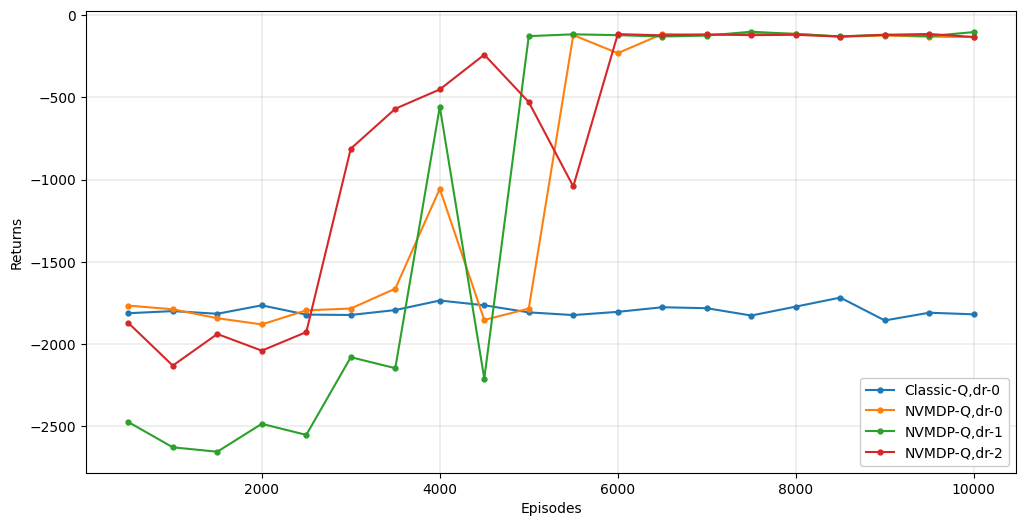

In [6]:
#Load the previous result file.
try:
    with open("Tricky_Gridworld_results.pkl", 'rb') as file: rptest_q_res = pickle.load(file)
except FileNotFoundError: print("!!warning: Tricky_Gridworld_results.pkl not exists!!")

#The function to change key names into legend names.
def key2leg(key):
    
    #Split the key name.
    s = key.split('-')
    #Change, combine, then return.
    return ('Classic-Q,' if 'clasc' == s[0] else 'NVMDP-Q,') + 'dr-' + s[1][1]
    #func-end

#Line chart.
(fig, ax) = plt.subplots(figsize = (12, 6))
#Generate the number of episodes.
epi_nums = 500 * np.arange(1, 20 + 1)
#Set the names for the axes.
ax.set_xlabel('Episodes')
ax.set_ylabel('Returns')
#Plot the returns.
legends = list()
for key in rptest_q_res.keys():
    if ('ln' in key) and (('clasc' in key) or (('nvmdp' in key) and ('g3' not in key))):
        ax.plot(epi_nums, rptest_q_res[key][0][2][: 20], marker = '.', markersize = 7)
        legends.append(key2leg(key))
    else: continue
    #for-end
ax.legend(legends, loc = 'lower right', framealpha = 1.)
ax.grid(True, linewidth = .3)
plt.show()

# Generalized Q-learning

## Maxmin Q-learning (6×1)

In [17]:
#The labels and environments.
lbls = tuple('mxm61' + suffix for suffix in ('-g0-ln', '-g1-ln', '-g2-ln', '-g1-sn', '-g2-sn', '-g3-ln'))
envts = (tgw, tgw_pun, tgw_pun2, tgw_pun_svn, tgw_pun2_svn, tgw_pun3)
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.Maxmin_AvalStruc, actions = tgw.actions(), est_num = 6, hist_num = 1)
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Loop through all environments.
for lbl, xenvt in zip(lbls, envts):
    #Record the start time.
    start_time = time.time()
    #Repeatedly test the Q-learning algorithm.
    rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, deepcopy(alpha), sp_num = 6, ovw = False)
    #Record the end time & calculate the elapsed time.
    end_time = time.time()
    print("%s: Elapsed time in seconds: %.6f" % (lbl, end_time - start_time))
    #for-end

mxm61-g0-ln: Elapsed time in seconds: 816.370814
mxm61-g1-ln: Elapsed time in seconds: 818.326742
mxm61-g2-ln: Elapsed time in seconds: 817.180751
mxm61-g1-sn: Elapsed time in seconds: 787.567636
mxm61-g2-sn: Elapsed time in seconds: 785.750937
mxm61-g3-ln: Elapsed time in seconds: 811.682254


## Maxmin Q-learning (3×2)

In [18]:
#The labels and environments.
lbls = tuple('mxm32' + suffix for suffix in ('-g0-ln', '-g1-ln', '-g2-ln', '-g1-sn', '-g2-sn', '-g3-ln'))
envts = (tgw, tgw_pun, tgw_pun2, tgw_pun_svn, tgw_pun2_svn, tgw_pun3)
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.Maxmin_AvalStruc, actions = tgw.actions(), est_num = 3, hist_num = 2)
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Loop through all environments.
for lbl, xenvt in zip(lbls, envts):
    #Record the start time.
    start_time = time.time()
    #Repeatedly test the Q-learning algorithm.
    rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, deepcopy(alpha), sp_num = 6, ovw = False)
    #Record the end time & calculate the elapsed time.
    end_time = time.time()
    print("%s: Elapsed time in seconds: %.6f" % (lbl, end_time - start_time))
    #for-end

mxm32-g0-ln: Elapsed time in seconds: 546.729676
mxm32-g1-ln: Elapsed time in seconds: 549.859204
mxm32-g2-ln: Elapsed time in seconds: 547.644308
mxm32-g1-sn: Elapsed time in seconds: 534.651580
mxm32-g2-sn: Elapsed time in seconds: 531.983458
mxm32-g3-ln: Elapsed time in seconds: 547.058224


## Maxmin Q-learning (2×3)

In [19]:
#The labels and environments.
lbls = tuple('mxm23' + suffix for suffix in ('-g0-ln', '-g1-ln', '-g2-ln', '-g1-sn', '-g2-sn', '-g3-ln'))
envts = (tgw, tgw_pun, tgw_pun2, tgw_pun_svn, tgw_pun2_svn, tgw_pun3)
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.Maxmin_AvalStruc, actions = tgw.actions(), est_num = 2, hist_num = 3)
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Loop through all environments.
for lbl, xenvt in zip(lbls, envts):
    #Record the start time.
    start_time = time.time()
    #Repeatedly test the Q-learning algorithm.
    rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, deepcopy(alpha), sp_num = 6, ovw = False)
    #Record the end time & calculate the elapsed time.
    end_time = time.time()
    print("%s: Elapsed time in seconds: %.6f" % (lbl, end_time - start_time))
    #for-end

mxm23-g0-ln: Elapsed time in seconds: 448.124146
mxm23-g1-ln: Elapsed time in seconds: 456.067664
mxm23-g2-ln: Elapsed time in seconds: 452.123646
mxm23-g1-sn: Elapsed time in seconds: 442.388213
mxm23-g2-sn: Elapsed time in seconds: 441.164474
mxm23-g3-ln: Elapsed time in seconds: 449.475555


## Maxmin Q-learning (1×6)

In [16]:
#The labels and environments.
lbls = tuple('mxm16' + suffix for suffix in ('-g0-ln', '-g1-ln', '-g2-ln', '-g1-sn', '-g2-sn', '-g3-ln'))
envts = (tgw, tgw_pun, tgw_pun2, tgw_pun_svn, tgw_pun2_svn, tgw_pun3)
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.Maxmin_AvalStruc, actions = tgw.actions(), est_num = 1, hist_num = 6)
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Loop through all environments.
for lbl, xenvt in zip(lbls, envts):
    #Record the start time.
    start_time = time.time()
    #Repeatedly test the Q-learning algorithm.
    rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, deepcopy(alpha), sp_num = 6, ovw = False)
    #Record the end time & calculate the elapsed time.
    end_time = time.time()
    print("%s: Elapsed time in seconds: %.6f" % (lbl, end_time - start_time))
    #for-end

mxm16-g0-ln: Elapsed time in seconds: 335.341044
mxm16-g1-ln: Elapsed time in seconds: 346.678683
mxm16-g2-ln: Elapsed time in seconds: 341.376506
mxm16-g1-sn: Elapsed time in seconds: 332.623336
mxm16-g2-sn: Elapsed time in seconds: 332.549947
mxm16-g3-ln: Elapsed time in seconds: 337.286480


## Present-Track-Maxmin Q-learning (6×1)

In [6]:
#The labels and environments.
lbls = tuple('ptm61' + suffix for suffix in ('-g0-ln', '-g1-ln', '-g2-ln', '-g1-sn', '-g2-sn', '-g3-ln'))
envts = (tgw, tgw_pun, tgw_pun2, tgw_pun_svn, tgw_pun2_svn, tgw_pun3)
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.PTMaxmin_AvalStruc, actions = tgw.actions(), est_num = 6, hist_num = 1)
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Loop through all environments.
for lbl, xenvt in zip(lbls, envts):
    #Record the start time.
    start_time = time.time()
    #Repeatedly test the Q-learning algorithm.
    rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, deepcopy(alpha), sp_num = 5, ovw = False)
    #Record the end time & calculate the elapsed time.
    end_time = time.time()
    print("%s: Elapsed time in seconds: %.6f" % (lbl, end_time - start_time))
    #for-end

!!rptest_q_learn.warning: skipped overwriting existing results!!
ptm61-g0-ln: Elapsed time in seconds: 0.059423
ptm61-g1-ln: Elapsed time in seconds: 1542.978297
ptm61-g2-ln: Elapsed time in seconds: 1544.432382
ptm61-g1-sn: Elapsed time in seconds: 1519.157052
ptm61-g2-sn: Elapsed time in seconds: 1515.657064
ptm61-g3-ln: Elapsed time in seconds: 1541.029802


## Present-Track-Maxmin Q-learning (3×2)

In [6]:
#The labels and environments.
lbls = tuple('ptm32' + suffix for suffix in ('-g0-ln', '-g1-ln', '-g2-ln', '-g1-sn', '-g2-sn', '-g3-ln'))
envts = (tgw, tgw_pun, tgw_pun2, tgw_pun_svn, tgw_pun2_svn, tgw_pun3)
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.PTMaxmin_AvalStruc, actions = tgw.actions(), est_num = 3, hist_num = 2)
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Loop through all environments.
for lbl, xenvt in zip(lbls, envts):
    #Record the start time.
    start_time = time.time()
    #Repeatedly test the Q-learning algorithm.
    rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, deepcopy(alpha), sp_num = 5, ovw = False)
    #Record the end time & calculate the elapsed time.
    end_time = time.time()
    print("%s: Elapsed time in seconds: %.6f" % (lbl, end_time - start_time))
    #for-end

!!rptest_q_learn.warning: skipped overwriting existing results!!
ptm32-g0-ln: Elapsed time in seconds: 0.020582
!!rptest_q_learn.warning: skipped overwriting existing results!!
ptm32-g1-ln: Elapsed time in seconds: 0.016411
!!rptest_q_learn.warning: skipped overwriting existing results!!
ptm32-g2-ln: Elapsed time in seconds: 0.014532
ptm32-g1-sn: Elapsed time in seconds: 838.308809
ptm32-g2-sn: Elapsed time in seconds: 842.409557
ptm32-g3-ln: Elapsed time in seconds: 855.145141


## Present-Track-Maxmin Q-learning (2×3)

In [6]:
#The labels and environments.
lbls = tuple('ptm23' + suffix for suffix in ('-g0-ln', '-g1-ln', '-g2-ln', '-g1-sn', '-g2-sn', '-g3-ln'))
envts = (tgw, tgw_pun, tgw_pun2, tgw_pun_svn, tgw_pun2_svn, tgw_pun3)
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.PTMaxmin_AvalStruc, actions = tgw.actions(), est_num = 2, hist_num = 3)
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Loop through all environments.
for lbl, xenvt in zip(lbls, envts):
    #Record the start time.
    start_time = time.time()
    #Repeatedly test the Q-learning algorithm.
    rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, deepcopy(alpha), sp_num = 6, ovw = False)
    #Record the end time & calculate the elapsed time.
    end_time = time.time()
    print("%s: Elapsed time in seconds: %.6f" % (lbl, end_time - start_time))
    #for-end

!!rptest_q_learn.warning: skipped overwriting existing results!!
ptm23-g0-ln: Elapsed time in seconds: 0.029238
ptm23-g1-ln: Elapsed time in seconds: 546.229318
ptm23-g2-ln: Elapsed time in seconds: 549.345175
ptm23-g1-sn: Elapsed time in seconds: 542.298563
ptm23-g2-sn: Elapsed time in seconds: 543.075711
ptm23-g3-ln: Elapsed time in seconds: 549.055535


## Present-Track-Maxmin Q-learning (1×6)

In [7]:
#The labels and environments.
lbls = tuple('ptm16' + suffix for suffix in ('-g0-ln', '-g1-ln', '-g2-ln', '-g1-sn', '-g2-sn', '-g3-ln'))
envts = (tgw, tgw_pun, tgw_pun2, tgw_pun_svn, tgw_pun2_svn, tgw_pun3)
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.PTMaxmin_AvalStruc, actions = tgw.actions(), est_num = 1, hist_num = 6)
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Loop through all environments.
for lbl, xenvt in zip(lbls, envts):
    #Record the start time.
    start_time = time.time()
    #Repeatedly test the Q-learning algorithm.
    rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, deepcopy(alpha), sp_num = 6, ovw = False)
    #Record the end time & calculate the elapsed time.
    end_time = time.time()
    print("%s: Elapsed time in seconds: %.6f" % (lbl, end_time - start_time))
    #for-end

ptm16-g0-ln: Elapsed time in seconds: 341.447974
ptm16-g1-ln: Elapsed time in seconds: 341.168507
ptm16-g2-ln: Elapsed time in seconds: 342.574787
ptm16-g1-sn: Elapsed time in seconds: 336.239859
ptm16-g2-sn: Elapsed time in seconds: 336.088316
ptm16-g3-ln: Elapsed time in seconds: 339.075103


## Average Q-learning (6×1)

In [7]:
#The labels and environments.
lbls = tuple('avg61' + suffix for suffix in ('-g0-ln', '-g1-ln', '-g2-ln', '-g1-sn', '-g2-sn', '-g3-ln'))
envts = (tgw, tgw_pun, tgw_pun2, tgw_pun_svn, tgw_pun2_svn, tgw_pun3)
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.Avg_AvalStruc, actions = tgw.actions(), est_num = 6, hist_num = 1)
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Loop through all environments.
for lbl, xenvt in zip(lbls, envts):
    #Record the start time.
    start_time = time.time()
    #Repeatedly test the Q-learning algorithm.
    rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, deepcopy(alpha), sp_num = 5, ovw = False)
    #Record the end time & calculate the elapsed time.
    end_time = time.time()
    print("%s: Elapsed time in seconds: %.6f" % (lbl, end_time - start_time))
    #for-end

avg61-g0-ln: Elapsed time in seconds: 1377.894395
avg61-g1-ln: Elapsed time in seconds: 1380.998225
avg61-g2-ln: Elapsed time in seconds: 1378.607495
avg61-g1-sn: Elapsed time in seconds: 1378.482816
avg61-g2-sn: Elapsed time in seconds: 1371.055328
avg61-g3-ln: Elapsed time in seconds: 1373.752073


## Average Q-learning (3×2)

In [6]:
#The labels and environments.
lbls = tuple('avg32' + suffix for suffix in ('-g0-ln', '-g1-ln', '-g2-ln', '-g1-sn', '-g2-sn', '-g3-ln'))
envts = (tgw, tgw_pun, tgw_pun2, tgw_pun_svn, tgw_pun2_svn, tgw_pun3)
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.Avg_AvalStruc, actions = tgw.actions(), est_num = 3, hist_num = 2)
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Loop through all environments.
for lbl, xenvt in zip(lbls, envts):
    #Record the start time.
    start_time = time.time()
    #Repeatedly test the Q-learning algorithm.
    rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, deepcopy(alpha), sp_num = 6, ovw = False)
    #Record the end time & calculate the elapsed time.
    end_time = time.time()
    print("%s: Elapsed time in seconds: %.6f" % (lbl, end_time - start_time))
    #for-end

avg32-g0-ln: Elapsed time in seconds: 709.207035
avg32-g1-ln: Elapsed time in seconds: 722.811215
avg32-g2-ln: Elapsed time in seconds: 720.518445
avg32-g1-sn: Elapsed time in seconds: 722.611747
avg32-g2-sn: Elapsed time in seconds: 719.084923
avg32-g3-ln: Elapsed time in seconds: 722.214904


## Average Q-learning (2×3)

In [8]:
#The labels and environments.
lbls = tuple('avg23' + suffix for suffix in ('-g0-ln', '-g1-ln', '-g2-ln', '-g1-sn', '-g2-sn', '-g3-ln'))
envts = (tgw, tgw_pun, tgw_pun2, tgw_pun_svn, tgw_pun2_svn, tgw_pun3)
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.Avg_AvalStruc, actions = tgw.actions(), est_num = 2, hist_num = 3)
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Loop through all environments.
for lbl, xenvt in zip(lbls, envts):
    #Record the start time.
    start_time = time.time()
    #Repeatedly test the Q-learning algorithm.
    rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, deepcopy(alpha), sp_num = 6, ovw = False)
    #Record the end time & calculate the elapsed time.
    end_time = time.time()
    print("%s: Elapsed time in seconds: %.6f" % (lbl, end_time - start_time))
    #for-end

avg23-g0-ln: Elapsed time in seconds: 570.867382
avg23-g1-ln: Elapsed time in seconds: 573.815860
avg23-g2-ln: Elapsed time in seconds: 571.455625
avg23-g1-sn: Elapsed time in seconds: 571.199650
avg23-g2-sn: Elapsed time in seconds: 569.054436
avg23-g3-ln: Elapsed time in seconds: 570.877059


## Average Q-learning (1×6)

In [9]:
#The labels and environments.
lbls = tuple('avg16' + suffix for suffix in ('-g0-ln', '-g1-ln', '-g2-ln', '-g1-sn', '-g2-sn', '-g3-ln'))
envts = (tgw, tgw_pun, tgw_pun2, tgw_pun_svn, tgw_pun2_svn, tgw_pun3)
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.Avg_AvalStruc, actions = tgw.actions(), est_num = 1, hist_num = 6)
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Loop through all environments.
for lbl, xenvt in zip(lbls, envts):
    #Record the start time.
    start_time = time.time()
    #Repeatedly test the Q-learning algorithm.
    rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, deepcopy(alpha), sp_num = 6, ovw = False)
    #Record the end time & calculate the elapsed time.
    end_time = time.time()
    print("%s: Elapsed time in seconds: %.6f" % (lbl, end_time - start_time))
    #for-end

avg16-g0-ln: Elapsed time in seconds: 404.127567
avg16-g1-ln: Elapsed time in seconds: 406.416478
avg16-g2-ln: Elapsed time in seconds: 403.683932
avg16-g1-sn: Elapsed time in seconds: 401.879879
avg16-g2-sn: Elapsed time in seconds: 404.020928
avg16-g3-ln: Elapsed time in seconds: 403.684931


## Weighted-Average Q-learning (6×1)

In [6]:
#The labels and environments.
lbls = tuple('wta61' + suffix for suffix in ('-g0-ln', '-g1-ln', '-g2-ln', '-g1-sn', '-g2-sn', '-g3-ln'))
envts = (tgw, tgw_pun, tgw_pun2, tgw_pun_svn, tgw_pun2_svn, tgw_pun3)
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.WtAvg_AvalStruc, actions = tgw.actions(), est_num = 6, hist_num = 1, la = .5, eta = .7)
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Loop through all environments.
for lbl, xenvt in zip(lbls, envts):
    #Record the start time.
    start_time = time.time()
    #Repeatedly test the Q-learning algorithm.
    rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, deepcopy(alpha), sp_num = 5, ovw = False)
    #Record the end time & calculate the elapsed time.
    end_time = time.time()
    print("%s: Elapsed time in seconds: %.6f" % (lbl, end_time - start_time))
    #for-end

!!rptest_q_learn.warning: skipped overwriting existing results!!
wta61-g0-ln: Elapsed time in seconds: 0.061296
!!rptest_q_learn.warning: skipped overwriting existing results!!
wta61-g1-ln: Elapsed time in seconds: 0.038806
wta61-g2-ln: Elapsed time in seconds: 2877.769301
wta61-g1-sn: Elapsed time in seconds: 2870.514202
wta61-g2-sn: Elapsed time in seconds: 2890.888815
wta61-g3-ln: Elapsed time in seconds: 2906.982325


## Weighted-Average Q-learning (3×2)

In [7]:
#The labels and environments.
lbls = tuple('wta32' + suffix for suffix in ('-g0-ln', '-g1-ln', '-g2-ln', '-g1-sn', '-g2-sn', '-g3-ln'))
envts = (tgw, tgw_pun, tgw_pun2, tgw_pun_svn, tgw_pun2_svn, tgw_pun3)
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.WtAvg_AvalStruc, actions = tgw.actions(), est_num = 3, hist_num = 2, la = .5, eta = .7)
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Loop through all environments.
for lbl, xenvt in zip(lbls, envts):
    #Record the start time.
    start_time = time.time()
    #Repeatedly test the Q-learning algorithm.
    rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, deepcopy(alpha), sp_num = 6, ovw = False)
    #Record the end time & calculate the elapsed time.
    end_time = time.time()
    print("%s: Elapsed time in seconds: %.6f" % (lbl, end_time - start_time))
    #for-end

wta32-g0-ln: Elapsed time in seconds: 1069.772323
wta32-g1-ln: Elapsed time in seconds: 1078.039589
wta32-g2-ln: Elapsed time in seconds: 1072.545848
wta32-g1-sn: Elapsed time in seconds: 1070.171272
wta32-g2-sn: Elapsed time in seconds: 1069.101602
wta32-g3-ln: Elapsed time in seconds: 1070.534535


## Weighted-Average Q-learning (2×3)

In [10]:
#The labels and environments.
lbls = tuple('wta23' + suffix for suffix in ('-g0-ln', '-g1-ln', '-g2-ln', '-g1-sn', '-g2-sn', '-g3-ln'))
envts = (tgw, tgw_pun, tgw_pun2, tgw_pun_svn, tgw_pun2_svn, tgw_pun3)
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.WtAvg_AvalStruc, actions = tgw.actions(), est_num = 2, hist_num = 3, la = .5, eta = .7)
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Loop through all environments.
for lbl, xenvt in zip(lbls, envts):
    #Record the start time.
    start_time = time.time()
    #Repeatedly test the Q-learning algorithm.
    rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, deepcopy(alpha), sp_num = 6, ovw = False)
    #Record the end time & calculate the elapsed time.
    end_time = time.time()
    print("%s: Elapsed time in seconds: %.6f" % (lbl, end_time - start_time))
    #for-end

wta23-g0-ln: Elapsed time in seconds: 713.766258
wta23-g1-ln: Elapsed time in seconds: 716.747632
wta23-g2-ln: Elapsed time in seconds: 716.594667
wta23-g1-sn: Elapsed time in seconds: 715.063939
wta23-g2-sn: Elapsed time in seconds: 710.243847
wta23-g3-ln: Elapsed time in seconds: 716.691441


## Weighted-Average Q-learning (1×6)

In [11]:
#The labels and environments.
lbls = tuple('wta16' + suffix for suffix in ('-g0-ln', '-g1-ln', '-g2-ln', '-g1-sn', '-g2-sn', '-g3-ln'))
envts = (tgw, tgw_pun, tgw_pun2, tgw_pun_svn, tgw_pun2_svn, tgw_pun3)
#Create an initializer of action-values.
init_f = partial(UBZ_NVMDP_TBL.WtAvg_AvalStruc, actions = tgw.actions(), est_num = 1, hist_num = 6, la = .5, eta = .7)
#Create a constant step size parameter.
def const_alpha(*args): return .1
alpha = UBZ_NVMDP_TBL.StepSize(None, const_alpha)

#Loop through all environments.
for lbl, xenvt in zip(lbls, envts):
    #Record the start time.
    start_time = time.time()
    #Repeatedly test the Q-learning algorithm.
    rptest_q_learn(lbl, 100, xenvt, 500, 100, 200, .05, init_f, deepcopy(alpha), sp_num = 6, ovw = False)
    #Record the end time & calculate the elapsed time.
    end_time = time.time()
    print("%s: Elapsed time in seconds: %.6f" % (lbl, end_time - start_time))
    #for-end

wta16-g0-ln: Elapsed time in seconds: 393.033823
wta16-g1-ln: Elapsed time in seconds: 395.867273
wta16-g2-ln: Elapsed time in seconds: 394.827277
wta16-g1-sn: Elapsed time in seconds: 393.393522
wta16-g2-sn: Elapsed time in seconds: 393.203695
wta16-g3-ln: Elapsed time in seconds: 395.640388


## Comparison: NVMDP-Q-learning vs Generalized Q-learning

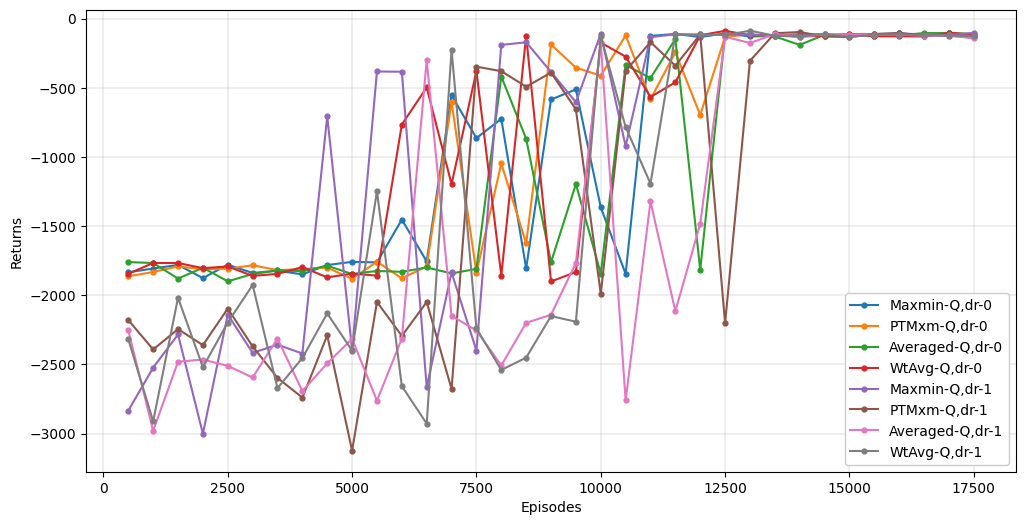

In [7]:
#Load the previous result file.
try:
    with open("Tricky_Gridworld_results.pkl", 'rb') as file: rptest_q_res = pickle.load(file)
except FileNotFoundError: print("!!warning: Tricky_Gridworld_results.pkl not exists!!")

#The function to change key names into legend names.
def key2leg(key):
    
    #Split the key name.
    s = key.split('-')
    #The full name of the algorithm.
    if 'mxm' == s[0][: 3]: algr_nam = 'Maxmin-Q'
    elif 'ptm' == s[0][: 3]: algr_nam = 'PTMxm-Q'
    elif 'avg' == s[0][: 3]: algr_nam = 'Averaged-Q'
    elif 'wta' == s[0][: 3]: algr_nam = 'WtAvg-Q'
    else: algr_nam = '#'
    #Combine, then return.
    return algr_nam + ',dr-' + s[1][1]
    #func-end

#Line chart.
(fig, ax) = plt.subplots(figsize = (12, 6))
#Generate the number of episodes.
epi_nums = 500 * np.arange(1, 35 + 1)
#Set the names for the axes.
ax.set_xlabel('Episodes')
ax.set_ylabel('Returns')
#Plot the returns.
legends = list()
for key in rptest_q_res.keys():
    if ('23' in key) and ('ln' in key) and ('g0' in key):
        ax.plot(epi_nums, rptest_q_res[key][0][3][: 35], marker = '.', markersize = 7)
        legends.append(key2leg(key))
    else: continue
    #for-end
for key in rptest_q_res.keys():
    if ('23' in key) and ('ln' in key) and ('g1' in key):
        ax.plot(epi_nums, rptest_q_res[key][0][3][: 35], marker = '.', markersize = 7)
        legends.append(key2leg(key))
    else: continue
    #for-end
ax.legend(legends, loc = 'lower right', framealpha = 1.)
ax.grid(True, linewidth = .3)
plt.show()

In [8]:
#Load the previous result file.
try:
    with open("Tricky_Gridworld_results.pkl", 'rb') as file: rptest_q_res = pickle.load(file)
except FileNotFoundError: print("!!warning: Tricky_Gridworld_results.pkl not exists!!")

#The function to change key names into algorithm names and parameter settings.
def key2names(key):
    
    #Split the key name.
    s = key.split('-')
    #The parameters are null by defautl.
    params = ' -- '
    #The full name of the algorithm.
    s0 = s[0]
    if 'mxm' == s0[: 3]: algr_nam, params = 'Maxmin-Q', f'n = {s0[3]}, l = {s0[4]}'
    elif 'ptm' == s0[: 3]: algr_nam, params = 'Present-Track-Maxmin-Q', f'n = {s0[3]}, l = {s0[4]}'
    elif 'avg' == s0[: 3]: algr_nam, params = 'Averaged-Q', f'n = {s0[3]}, l = {s0[4]}'
    elif 'wta' == s0[: 3]: algr_nam, params = 'Weighted-Average-Q', f'n = {s0[3]}, l = {s0[4]}'
    elif 'clasc' == s0: algr_nam = 'Classic-Q'
    elif 'nvmdp' == s0: algr_nam = 'NVMDP-Q'
    else: algr_nam = 'Unknown Algr'
    #The reward settings.
    rwd_nam = 'r-lvn' if 'ln' == s[2] else 'r-svn'
    #The discount rate configurations.
    gam_nam = 'dr-' + s[1][1]
    #Return the algorithm names, parameter settings, reward settings, and the discount rate configurations.
    return algr_nam, params, rwd_nam, gam_nam
    #func-end

#Print the header.
print("Algorithm\tParameters\tReward\tDiscount Rates\tEpisodes\tSteps\tstd\tcount")
#Loop through all results.
for k, v in rptest_q_res.items():
    
    #Get the algorithm names, parameter settings, reward settings, and the discount rate configurations.
    algr_nam, params, rwd_nam, gam_nam = key2names(k)
    #Calculate the average episodes before reaching convergence to optimality.
    avg_epi = np.mean(v[2])
    #Get the cut points of convergence to optimality.
    cuts = np.divide(v[2], 500).astype(np.int32) - 1
    #Calculate the return std & average steps before reaching convergence to optimality.
    std_seq, steps_seq = list(), list()
    for ret_seq, steps_seq, cut in zip(v[0], v[1], cuts):
        std_seq.append(np.std(ret_seq[: cut], ddof = 1))
        steps_seq.append(steps_seq[min(cut, 99)])
        #inner-for-end
    avg_std = np.mean(std_seq)
    avg_steps = np.mean(steps_seq)
    #Calculate the sum of trajectory number that passing through punishment locations.
    pas_pun_ct = sum(v[3])
    #Print the results.
    print(algr_nam, '\t', params, '\t', rwd_nam, '\t', gam_nam, '\t', avg_epi, f'\t{avg_steps: .2f}\t{avg_std: .2f}', '\t', pas_pun_ct)
    #for-end

Algorithm	Parameters	Reward	Discount Rates	Episodes	Steps	std	count
Classic-Q 	  --  	 r-lvn 	 dr-0 	 50500.0 	 4546958.34	 39.04 	 71
NVMDP-Q 	  --  	 r-lvn 	 dr-0 	 6140.0 	 1219650.27	 656.99 	 88
NVMDP-Q 	  --  	 r-lvn 	 dr-1 	 6185.0 	 1216526.57	 963.11 	 23
NVMDP-Q 	  --  	 r-svn 	 dr-1 	 5990.0 	 1206983.31	 887.86 	 0
NVMDP-Q 	  --  	 r-lvn 	 dr-2 	 6495.0 	 1217897.96	 759.47 	 19
NVMDP-Q 	  --  	 r-svn 	 dr-2 	 5920.0 	 1210167.30	 734.38 	 0
NVMDP-Q 	  --  	 r-lvn 	 dr-3 	 6195.0 	 1216483.61	 960.29 	 2
Maxmin-Q 	 n = 1, l = 6 	 r-lvn 	 dr-0 	 6465.0 	 1231577.23	 652.13 	 88
Maxmin-Q 	 n = 1, l = 6 	 r-lvn 	 dr-1 	 6460.0 	 1229094.92	 965.25 	 28
Maxmin-Q 	 n = 1, l = 6 	 r-lvn 	 dr-2 	 6435.0 	 1231536.80	 780.15 	 33
Maxmin-Q 	 n = 1, l = 6 	 r-svn 	 dr-1 	 6050.0 	 1207742.21	 925.91 	 0
Maxmin-Q 	 n = 1, l = 6 	 r-svn 	 dr-2 	 6015.0 	 1209271.43	 742.52 	 0
Maxmin-Q 	 n = 1, l = 6 	 r-lvn 	 dr-3 	 6410.0 	 1224127.61	 982.18 	 0
Maxmin-Q 	 n = 6, l = 1 	 r-lvn 	 dr-